In [57]:
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import seaborn as sns
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer


from sklearn.pipeline import Pipeline


In [51]:
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gowthamkishorevijay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:

# Load the CSV file (replace this path with your actual file path)
file_path = '/Users/gowthamkishorevijay/Desktop/Playground/projects/my-venv/CEAS_08.csv'  # Adjust based on your local environment
df = pd.read_csv(file_path)

In [62]:
def extract_urls(text):
    if not isinstance(text, str):
        return []
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    urls = re.findall(url_pattern, text)
    return urls

# Function to clean email body
def clean_text(text):
    if not isinstance(text, str):
       text = ''
    

    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'>+=+=+=+=+', '', text)  # Removing separators like '+=+=+=+=+=+'
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and digits
    
    # 3. Lowercase the text
    text = text.lower()
    
    # 4. Remove non-alphabetic characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 5. Remove stopwords
    text_tokens = text.split()
    filtered_words = [word for word in text_tokens if word not in stop_words]
    
    return ' '.join(filtered_words)

# Apply URL extraction and data cleaning
df['extracted_urls'] = df['body'].apply(extract_urls)
df['body'] = df['body'].apply(clean_text)



print(df[['sender', 'subject', 'body', 'extracted_urls', 'label']].head())

                                              sender  \
0                   Young Esposito <Young@iworld.de>   
1                       Mok <ipline's1983@icable.ph>   
2  Daily Top 10 <Karmandeep-opengevl@universalnet...   
3                 Michael Parker <ivqrnai@pobox.com>   
4  Gretchen Suggs <externalsep1@loanofficertool.com>   

                                             subject  \
0                          Never agree to be a loser   
1                             Befriend Jenna Jameson   
2                               CNN.com Daily Top 10   
3  Re: svn commit: r619753 - in /spamassassin/tru...   
4                         SpecialPricesPharmMoreinfo   

                                                body  \
0  buck troubles caused small dimension soon beco...   
1                   upgrade sex pleasures techniques   
2  daily top cnncom top videos stories aug pm edt...   
3  would anyone object removing list tld basicall...   
4                 welcomefastshippingcustomers

In [96]:

# Features and labels
X = df[['body', 'extracted_urls', 'subject']]
y = df['label']

# Ensure the text columns are strings
def column_as_string(X):
    return X.astype(str)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Preprocessor: handling 'body' and 'extracted_urls' separately
preprocessor = ColumnTransformer(
    transformers=[
        ('body', Pipeline([
            ('convert_to_str', FunctionTransformer(column_as_string, validate=False)),
            ('tfidf', TfidfVectorizer())
        ]), 'body'),
        ('extracted_urls', Pipeline([
            ('convert_to_str', FunctionTransformer(column_as_string, validate=False)),
            ('tfidf', TfidfVectorizer())
        ]), 'extracted_urls')
    ])

# Create 

# Create the full pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('nb', RandomForestClassifier())
])

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# You can now evaluate your model
from sklearn.metrics import classification_report
print("Train Set Performance:")
print(classification_report(y_train, y_pred_train))
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred_test))



Train Set Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13822
           1       1.00      1.00      1.00     17501

    accuracy                           1.00     31323
   macro avg       1.00      1.00      1.00     31323
weighted avg       1.00      1.00      1.00     31323


Test Set Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3490
           1       0.99      0.99      0.99      4341

    accuracy                           0.99      7831
   macro avg       0.99      0.99      0.99      7831
weighted avg       0.99      0.99      0.99      7831




Train ROC AUC: 1.0
Test ROC AUC: 0.9930780939255147


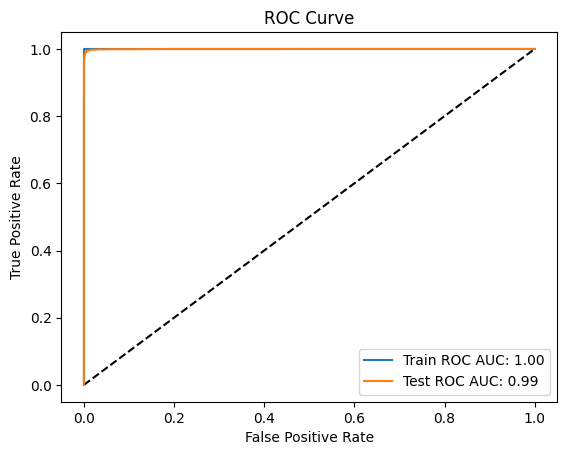


Confusion Matrix:


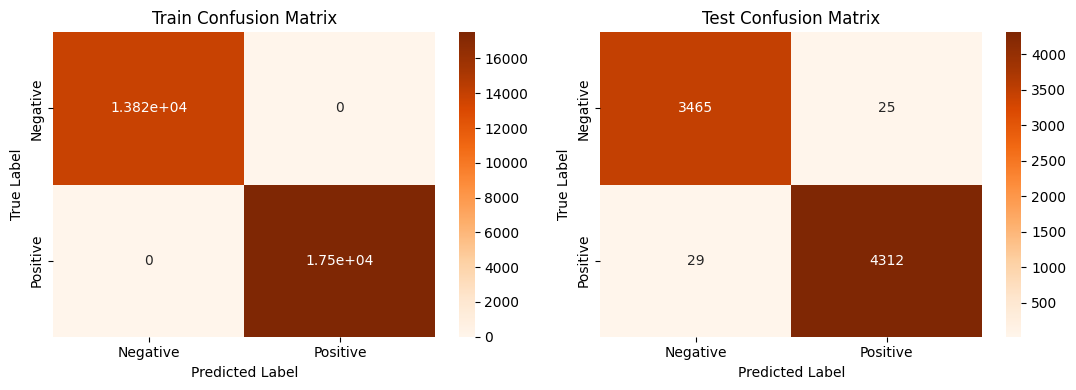

In [78]:
pred_prob_train = model.predict_proba(X_train)[:,1]
pred_prob_test = model.predict_proba(X_test)[:,1]

# calculate ROC AUC score
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print("\nTrain ROC AUC:", roc_auc_train)
print("Test ROC AUC:", roc_auc_test)

# plot the ROC curve
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_prob_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_prob_test)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_train, tpr_train, label="Train ROC AUC: {:.2f}".format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label="Test ROC AUC: {:.2f}".format(roc_auc_test))
plt.legend()
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# calculate confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(11,4))

print("\nConfusion Matrix:")
sns.heatmap(cm_train, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[0])
ax[0].set_xlabel("Predicted Label")
ax[0].set_ylabel("True Label")
ax[0].set_title("Train Confusion Matrix")

sns.heatmap(cm_test, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[1])
ax[1].set_xlabel("Predicted Label")
ax[1].set_ylabel("True Label")
ax[1].set_title("Test Confusion Matrix")

plt.tight_layout()
plt.show()

In [97]:
new_email_body = """hey mate, i saw your pull request, its good actually, but i feel some changes can be done, look on that and fix that"""
def clean_text(text):
    if not isinstance(text, str):
       text = ''
    

    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'>+=+=+=+=+', '', text)  # Removing separators like '+=+=+=+=+=+'
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and digits
    
    # 3. Lowercase the text
    text = text.lower()

    print(text)
    
    # 4. Remove non-alphabetic characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 5. Remove stopwords
    text_tokens = text.split()
    filtered_words = [word for word in text_tokens if word not in stop_words]
    
    return ' '.join(filtered_words)

# Apply the same preprocessing steps (extract URLs and clean text)
new_email_body = clean_text(new_email_body)  # Clean the email body
new_email_urls = extract_urls(new_email_body)  # Extract URLs

# Create a DataFrame similar to the one used for training
new_email_df = pd.DataFrame({
    'body': [new_email_body],
    'extracted_urls': [' '.join(new_email_urls)]
})

print(new_email_df)

# Make a prediction using the model pipeline
prediction = model.predict(new_email_df)

# Print the prediction result
if prediction == 0:
    print("This is not a spam Email!")
else:
    print("This is a Spam Email!")

hey mate i saw your pull request its good actually but i feel some changes can be done look on that and fix that
                                                body extracted_urls
0  hey mate saw pull request good actually feel c...               
This is not a spam Email!
